In [1]:
import sys
sys.path.append("../")

In [37]:
import os.path as op
import random

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple


import pandas as pd
import yaml

from agents import GreedyAgent,RandomAgent
from agents.matchmanager import MatchManager
from agents.ml.classifier import ClassifierAgent
from agents.ml.regression import RegressionAgent
from agents.ml.regressionMulti import RegressionMultiAgent

from core.const import RED, BLUE
from core.game import GameBoard, GameState, vectorState, vectorStateInfo
from core.vectors import vectorAction, vectorActionInfo, vectorBoard, vectorBoardInfo
from scenarios import scenarioJunction
import warnings
import datetime

from sklearn import preprocessing

from multiprocessing import Pool

from itertools import product
import json

import os
from utils.setup_logging import setup_logging




%matplotlib inline
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.figsize'] = (12,4)


In [3]:
def player(team:str, data:tuple, seed:int):
    if data[0] == 'gre':
        print(f'{team:5}-> GreedyAgent')
        return GreedyAgent(team, seed=seed)
    if data[0] == 'cls':
        print(f'{team:5}-> ClassifierAgent')
        return ClassifierAgent(team, data[1], seed=seed)
    if data[0] == 'reg':
        print(f'{team:5}-> RegressionAgent')
        return RegressionAgent(team, data[1], seed=seed)
    if data[0]=='ran':
        print(f'{team:5}-> RandomAgent')
        return RandomAgent(team, seed=seed)
    if data[0]=='regMulti':
        print(f'{team:5}-> RegressionAgentMulti')


        return RegressionMultiAgent(team,data[1],data[2],data[3],seed=seed)


    
    return None

In [4]:
def game(seed:int, red:tuple, blue:tuple) -> MatchManager:
    scenarios=[scenarioJunction]
    for s in scenarios:
        board, state = s()

        print('seed:   ', seed)

        playerRed = player(RED, red, seed)
        playerBlue = player(BLUE, blue, seed)

        mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
        while not mm.end:
            mm.nextStep()

        print('winner: ', mm.winner)

        return mm,board.name

In [5]:
def prepareDataFrames(mm:MatchManager):
    df_states = pd.DataFrame(
        columns=vectorStateInfo(),
        data=[vectorState(x) for x in mm.states_history]
    )

    df_actions = pd.DataFrame(
        columns=vectorActionInfo(),
        data=[vectorAction(x) for x in mm.actions_history]
    )
    df_red = mm.red.createDataFrame()
    df_blue = mm.blue.createDataFrame()
    df_red['winner']=mm.winner
    df_blue['winner']=mm.winner
    
    df_red = df_red.set_index('count')
    df_blue = df_blue.set_index('count')

    return df_red, df_blue, df_states, df_actions

In [6]:
def plotEntropy(df, color:str,data,winner,ax):
    df.score.plot(color=color, marker='.',ax=ax)
    df.entropy.plot(color='purple',ax=ax)
    df.standard_deviation.plot(color='green',ax=ax)

    for i, row in df[['score','action']].reset_index().iterrows():
        dy, ha, va = (-0, 'center', 'top') if 'Respond' in row.action else (10, 'center', 'bottom')
        ax.annotate(row.action, (row['count'], row.score), ha=ha, va=va, rotation=90, textcoords="offset points", xytext=(0,dy))
        
    for x in df[['turn']].reset_index().groupby('turn').max().values.tolist():
        ax.axvline(x=x[0]+0.5, color='orange')
    ax.legend(framealpha=1, frameon=True,loc='center left',bbox_to_anchor=(1,0.5))
    title=f'Entropy and Score for agent->{data[0]}. Winner:{winner} '

    ax.set_title(title)


    

In [7]:
def setTime(df):
    df['time'] = pd.to_datetime(df['time'],errors='coerce')
    df['time']=df['time'].dt.time
    df= df.reset_index()
    x=df['time'].tolist()
    y=df['score'].tolist()
    df= df.set_index('time')
    return df,x,y


In [8]:
def setScore(df,model_path):
    model=joblib.load(os.path.join(os.getcwd(), model_path[1]))
    df['score']=model.predict(df['score'])
    return df

In [108]:
def plotEntropyTime(df_red,df_blue,red_data,blue_data,winner,scenario):
    position=[]
    labels=df_red['turn'].unique()
    loser='blue' if winner == 'red' else 'red'
    
    markers={'Attack':'o',
             'AttackGround':'p',
             'Move':'D',
            'MoveLoadInto':'*',
            'PassFigure':'v',
             'Pass':'P',
             'PassTeam':'+',
             'AttackRespond':'X',
             'PassRespond':'s',
            }
    
    df_red,x_red,y_red=setTime(df_red)
    df_blue,x_blue,y_blue=setTime(df_blue)
    df_red['standard_deviation']=df_red['standard_deviation'].mul(-1)
    dataframes={'red':df_red,
               'blue':df_blue}

    fig, ax = plt.subplots()
    '''for i in dataframes:
        dataframes[i].score.plot(color=i,legend=False,ax=ax)
        dataframes[i].standard_deviation.plot(color=i,ax=ax,style='--',linewidth=0.5,label='entropy',legend=False)
        for a in dataframes[i]['action'].unique():
            dataframes[i].loc[dataframes[i]["action"] == a].score.plot(color=i,marker=markers[a],linestyle='None',label=a,legend=False)
    lista = [child for child in ax.get_children() if isinstance(child, Line2D)]'''
    
     
    df_red.score.plot(color='red',legend=False,ax=ax,label='_nolegend_')
    df_blue.score.plot(color='blue',legend=False,ax=ax,label='_nolegend_')
    df_red.standard_deviation.plot(color='red',legend=False,ax=ax,style='--',linewidth=0.5,label='_nolegend_')
    df_blue.standard_deviation.plot(color='blue',legend=False,ax=ax,style='--',linewidth=0.5,label='_nolegend_')
    p1,p2,p3,p4 = [child for child in ax.get_children()
         if isinstance(child, Line2D)]
    for i in dataframes:
        for a in dataframes[i]['action'].unique():
            dataframes[i].loc[dataframes[i]["action"] == a].score.plot(color=i,marker=markers[a],linestyle='None',label=a,legend=False)
    handles, labels = ax.get_legend_handles_labels()

    

            

    for x in df_red[['turn']].reset_index().groupby('turn').min().values.tolist():
        delta=datetime.timedelta(milliseconds=20)
        turn=(datetime.datetime.combine(datetime.date(1,1,1),x[0]) - delta).time()
        ax.axvline(x=turn, color='black',linewidth=0.7)
        position.append(turn)

    ax.vlines(x_red, -1, y_red, linestyle=':',linewidth=0.5,color='magenta')
    ax.vlines(x_blue, -1, y_blue, linestyle=':',linewidth=0.5,color='cyan')
    ax.axhline(color='black',linewidth=0.5)

        
    plt.xticks(position, labels)
    plt.yticks([-1,0,1], ['likely to win','neutral','likely to lose'])

    legend_elements = [Line2D([0], [0], color='red', label=f'Attacker ->{red_data[0]}'),
                   Line2D([0], [0], color='blue', label=f'Defender ->{blue_data[0]}')]

    leg0=ax.legend(bbox_to_anchor=(1.04, 0), loc='lower left')
    leg1 = ax.legend([(p1, p2), (p3,p4)], ['score', 'entropy'],bbox_to_anchor=(1.04,1), loc="upper left",
               handler_map={tuple: HandlerTuple(ndivide=None)})    
    leg2 = ax.legend(handles=legend_elements, loc='upper left')
    ax.add_artist(leg1)
    ax.add_artist(leg0)
    ax.set_ylim(-1,+1)
    ax.set_xlabel('Turn')
    title=f'Scenario: {scenario}. Winner: {winner}. Loser: {loser} '

    ax.set_title(title)




    

In [10]:
def plotContrast(df):
    df[df['team']=='red']['entropy'].plot(color='red'), df[df['team']=='blue']['entropy'].plot(color='blue')

In [11]:
def playAndAnalyzeTime(seed:int, red_data, blue_data):  
    mm,scenario = game(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    plotEntropyTime(df_red,df_blue,red_data,blue_data,mm.winner,scenario)
    
    plt.show()
    
    return df_red, df_blue

In [12]:
def playAndAnalyze(seed:int, red_data, blue_data):  
    mm,scenario = game(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
    plotEntropy(df_red, 'red',red_data,mm.winner,ax1)
    plotEntropy(df_blue, 'blue',blue_data,mm.winner,ax2)
    
    plt.show()
    
    return df_red, df_blue

In [13]:
def play(seed:int, red_data, blue_data):  
    mm,scenario = game(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    return df_red, df_blue

In [14]:
red_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_red_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_red_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_red_attack_20210301.joblib','../models/Junction_RandomForestRegressor_red_move_20210301.joblib','../models/Junction_RandomForestRegressor_red_pass_20210301.joblib')

]
blue_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_blue_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_blue_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_blue_attack_20210301.joblib','../models/Junction_RandomForestRegressor_blue_move_20210301.joblib','../models/Junction_RandomForestRegressor_blue_pass_20210301.joblib')


]

In [ ]:
    setup_logging()


In [15]:
s=51

seed:    51
red  -> RegressionAgentMulti
blue -> RegressionAgent


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


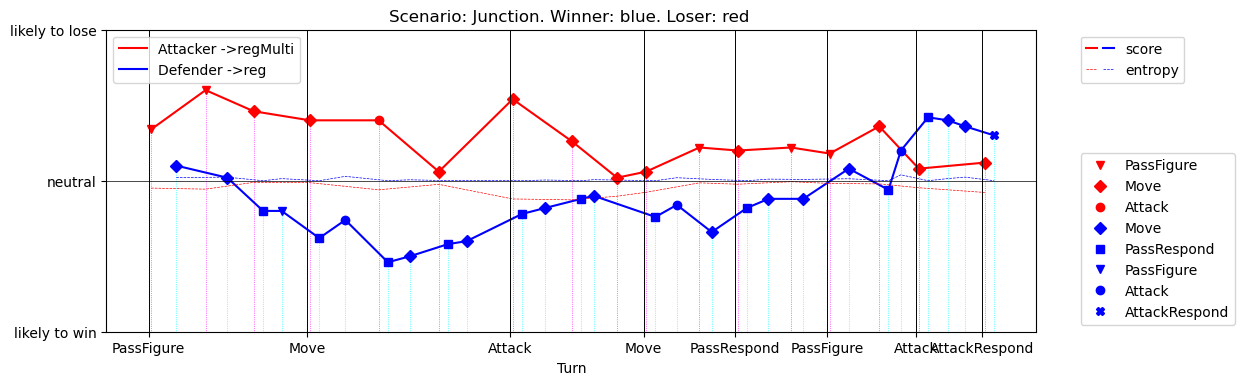

In [109]:
df_red,df_blue=playAndAnalyzeTime(51, red_models[5], blue_models[3])


In [ ]:
df_red['time'].tolist()

In [ ]:
df_red,df_blue=playAndAnalyze(s, red_models[0], blue_models[3])


In [ ]:
df_red,df_blue=playAndAnalyzeTime(s, red_models[0], blue_models[3])

# praticamente le mosse che mi escono da eventuali agenti li mando in pasto al modello regressore con predict() e plotto quello.




In [ ]:
df_red

In [ ]:
import joblib

In [ ]:
model=joblib.load(os.path.join(os.getcwd(), model_path[1]))


In [ ]:
df_red,df_blue=playAndAnalyzeTime(1340, red_models[0], blue_models[3])


## Tourney 

In [ ]:
dfs=[]
for i in range(3):
    s = random.randint(0, 1000000)
    r = random.randint(0, len(red_models)-1)
    b = random.randint(0, len(blue_models)-1)
    df_red,df_blue=playAndAnalyzeTime(s, red_models[r], blue_models[b])
    dfs.append(df_red)
    dfs.append(df_blue)
df=pd.concat(dfs).reset_index()

## Entropy regressor

In [ ]:
def plotgroupAgentePartita(df,value_y,kind):
    fig, axes = plt.subplots(len(df['team'].unique()),len(df['seed'].unique()), figsize=(15,10))
    for (joinGroup, group), ax in zip(df.groupby(['team','seed']), axes.flatten()):
        win=group['winner'].unique()
        title=f'{joinGroup}-> winner:{win}'
        group.plot(x='count', y=value_y, kind=kind,style='-o' ,ax=ax,title=title,ylim=[-1,1])

In [ ]:
plotgroupAgentePartita(df,'score','bar')

In [ ]:
plotgroupAgentePartita(df,'entropy','bar')

plotgroupAgentePartita(df,'Score','scatter')

plotgroupAgentePartita(df,'Entropia','scatter')

plotgroupAgentePartita(df,'Score','line')

plotgroupAgentePartita(df,'Entropia','line')

plotgroupAgentePartita(df,'Score','box')

plotgroupAgentePartita(df,'Entropia','box')

In [ ]:
def entropyAndScore(df,kind):
    fig, axes = plt.subplots(len(df['team'].unique()),len(df['seed'].unique()), figsize=(15,10))
    for (joinGroup, group), ax in zip(df.groupby(['team','seed']), axes.flatten()):
        win=group['winner'].unique()
        title=f'{joinGroup}-> winner:{win}'
        group.plot(x='count', y=['score'], kind=kind,style='-o', ax=ax,title=title,ylim=[-1,1],color='r')
        group.plot(x='count', y=['entropy'], kind=kind,style='-o', ax=ax,title=title,ylim=[-1,1],color='b')

In [ ]:
entropyAndScore(df,'scatter')

entropyAndScore(df,'line')

fig, axes = plt.subplots(1,len(df['seed'].unique()), figsize=(15,5))
for (joinGroup, group), ax in zip(df.groupby(['seed']), axes.flatten()):
    win=group['winner'].unique()
    title=f'{joinGroup}-> winner:{win}'
    group.plot(x=['count'], y=['score'], kind='scatter', ax=ax,title=title,ylim=[-1,1],c='team')


plot=df.groupby(['team','seed']).plot.bar(y='entropy')

boxplot=df.boxplot(column=['score', 'entropy'],by='team')


boxplot=df.boxplot(column=['score', 'entropy'],by='seed')

boxplot=df.boxplot(column=['score', 'entropy'],by=['seed','team'])

plot=df.groupby('team').plot.scatter(x='count',y='entropy',c='team')

plot=df.groupby('team').plot.scatter(x='count',y='score',c='team')